# MAPDb - Final Project

## Streaming processing of cosmic rays using Drift Tubes detectors

The goal of this project is to reproduce a real-time processing of real data collected in a particle physics detector and publish the results in a dashboard for live monitoring.

### Students:
* Conforto Filippo (2021856)
* Domenichetti Lorenzo (2011653)
* Faorlin Tommaso (2021857)

## Spark cluster

<img src="Pictures/cluster.png" alt="drawing" width="800"/>

Why we choose this architecture. After ```cp spark-defaults.conf.template spark-defaults.conf``` we modify this file adding the following lines:

```
spark.executor.memory          1800m
spark.executor.instances          15
spark.executor.cores               1
```
In the end we will instantiate in total **15 executors** (3 for each Worker node) with **one cores each** and **1800 mebibytes** (~1.89 GB) of RAM. We also tried with 10 executors and two cores each and in the end we obtain more or less the same preformances in the long run (after the initial 'stabilization phase'). We chose in the end the first configuration to be sure we are leaving one core and $\approx1$ GB of RAM free for other VMs operations. 

We notice that leaving one core free allows to have a more stable input rate.
<br><br>
<br><br>

<br><br>
<br><br>

The Spark Session

In [ ]:
#initialisation of spark from the packages folder
findspark.init('/usr/local/spark')

#start session - specify port, application name, and configuration settings
spark = SparkSession.builder\
    .master("spark://master:7077")\
    .appName("MAPD Final Project session")\
    .config("spark.jars.packages","org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2")\
    .getOrCreate()

#default parallelism setting to shuffle different partitions between workers
#after join or groupBy operations
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism)

## Kafka server setup

The two Kafka topics *topic_stream* and *topic_results* are created with a **single** partition. For *topic_results*, this choice reflects the necessity of having a single stream of results to implement the dashboard, while for *topic_stream* allows for each executor to stream in parallel the incoming data. We have also tried to increase this number (```num_partitions=2``` and ```num_partitions=4```) without having any improvement in the final batch processing rate.

## One script to rule them all

The cluster is created using a single script: ```/usr/local/spark/sbin/start-all.sh``` after exchanging ssh keys between master and slaves and setting up spark configuration.


```#! /bin/bash```

```sh /usr/local/spark/sbin/start-all.sh```

```sleep 1```

```ssh slave04 sh /home/packages/kafka_2.13-2.7.0/bin/zookeeper-server-start.sh /home/packages/kafka_2.13-2.7.0/config/zookeeper.properties &```

```sleep 1```

```ssh slave04 sh /home/packages/kafka_2.13-2.7.0/bin/kafka-server-start.sh /home/packages/kafka_2.13-2.7.0/config/server.properties &%```

# Producer

In [ ]:
#SSL context to dowload without errors data from the given server
ssl._create_default_https_context = ssl._create_unverified_context

#define the kafka server from IP and Port
KAFKA_BOOTSTRAP_SERVERS = 'slave04:9092'

#producer definition from IP address given before
producer = KafkaProducer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS)


for i in range(0, 81):
    #data download from s3 bucket
    i = str(i).zfill(2)
    url = f"https://cloud-areapd.pd.infn.it:5210/swift/v1/\
            AUTH_d2e941ce4b324467b6b3d467a923a9bc/MAPD_miniDT_stream/data_0000{i}.txt"
    df = pd.read_csv(url)
    
    #data cleaning for possible outliers
    df = df[df.ORBIT_CNT < 5e8]
    print(f"Reading file data_0000{i}.txt")
    
    #for loop over file size
    for j in tqdm(range(0, df.shape[0])):
        
        #dictionaries creation from dataframe's rows
        jj = df.iloc[j].to_dict()
        
        #unnecessary floats are cast into ints
        for key in ['HEAD', 'FPGA', "TDC_CHANNEL"]:
            jj[key] = int(jj[key])
            
        #json row is sent to the Kafka topic 'topic_stream'
        producer.send('topic_stream',
                      json.dumps(jj).encode('utf-8')
                     )
        time.sleep(0.0003)
        
    producer.flush()

<br><br>
<br><br>
<br><br>

# Computation

In [ ]:
#define the kafka server from IP and Port
KAFKA_BOOTSTRAP_SERVERS = "slave04:9092" #on the fourth VM 

#define the input dataframe and its source. Define subscription to 'topic_stream'
inputDF = spark\
        .readStream\
        .format("kafka")\
        .option("kafka.bootstrap.servers", KAFKA_BOOTSTRAP_SERVERS)\
        .option('subscribe', 'topic_stream')\
        .load()

In [ ]:
#define the schema of the rows that will be read
#double are used to overcome overflow issues
schema = StructType(
        [StructField("HEAD",        IntegerType()),
         StructField("FPGA",         IntegerType()),
         StructField("TDC_CHANNEL",  IntegerType()),
         StructField("ORBIT_CNT",    DoubleType()),
         StructField("BX_COUNTER",   DoubleType()), 
         StructField("TDC_MEAS",    DoubleType() )]
)

In [ ]:
#convert input_Df to json by casting columns into the predefined schema.
jsonDF = inputDF.select(from_json(col("value").alias('value').cast("string"),
                                  schema).alias('value'))

In [ ]:
#flattening the dataframe
flatDF = jsonDF.selectExpr("value.HEAD", 
                           "value.FPGA", 
                           "value.TDC_CHANNEL",
                           "value.ORBIT_CNT",
                           "value.BX_COUNTER",
                           "value.TDC_MEAS")

In [ ]:
#clean dataframe, removing ancillary hits
df = flatDF.where(col("HEAD")==2)

In [ ]:
#scintillator time offset by Chamber
time_offset_by_chamber = {
0: 95.0 - 1.1, # Ch 0
1: 95.0 + 6.4, # Ch 1
2: 95.0 + 0.5, # Ch 2
3: 95.0 - 2.6, # Ch 3
}

#bins definition for histograms - they will be shared among all iterations.
binning = list(linspace(0, 4e8, 100))

binning_drift = list(linspace(0, 800, 40))

In [ ]:
def batch_proc(batch_df, epoch_id):
    
    #repartition the df DataFrame to 100 parts
    #and persist in cache to speedup calculations
    batch_df.coalesce(15)
    batch_df.persist()
    
    #Dividing the dataframe between chambers
    batch_df_ch0 = batch_df.filter('(FPGA==0) AND (TDC_CHANNEL >= 0) AND (TDC_CHANNEL < 64)')
    batch_df_ch1 = batch_df.filter('(FPGA==0) AND (TDC_CHANNEL >= 64) AND (TDC_CHANNEL < 128)')
    batch_df_ch2 = batch_df.filter('(FPGA==1) AND (TDC_CHANNEL >= 0) AND (TDC_CHANNEL < 64)')
    batch_df_ch3 = batch_df.filter('(FPGA==1) AND (TDC_CHANNEL >= 64) AND (TDC_CHANNEL < 128)')
    
    #coalesce + persist for each filtered batch
    batch_df_ch0.coalesce(15)
    batch_df_ch1.coalesce(15)
    batch_df_ch2.coalesce(15)
    batch_df_ch3.coalesce(15)
    batch_df_ch0.persist()
    batch_df_ch1.persist()
    batch_df_ch2.persist()
    batch_df_ch3.persist()    
       
    #list of dfs_ handy for loops
    batch_dfs = [batch_df_ch0, batch_df_ch1, batch_df_ch2, batch_df_ch3]
    
    #counting hits for each chamber
    hits_ch0 = batch_df_ch0.count()
    hits_ch1 = batch_df_ch1.count()
    hits_ch2 = batch_df_ch2.count()
    hits_ch3 = batch_df_ch3.count()
    
    #total number of hits as the sum of the previous 4 operations
    hits = hits_ch0 + hits_ch1 + hits_ch2 + hits_ch3
    
    if hits!=0: 

        #dataframe containing only informations about scintillator events
        batch_df_scint = (batch_df.filter('(FPGA==1) AND (TDC_CHANNEL == 128)')
                          .select(['ORBIT_CNT', 'BX_COUNTER',"TDC_MEAS"])
                          .groupBy('ORBIT_CNT')
                          .min()
                          .withColumnRenamed("min(BX_COUNTER)", 'BX_COUNTER_SCINT')
                          .withColumnRenamed("min(TDC_MEAS)", 'TDC_MEAS_SCINT')
                          .drop('min(ORBIT_CNT)')
                         )

        #total active channels histogram
        hist1 = {}
        
        #channels per orbit histogram 
        hist2 = {}

        #active channels in orbits in which the scintillator is active histogram
        hist3 = {}

        #drifttime histogram
        hist4 = {}
        
        #loop over the four chambers
        for chamber in [0,1,2,3]:
            #create an empty dictionary for each type of histogram corresponding to the selected chamber
            hist1[chamber] = {}
            hist2[chamber] = {}
            hist3[chamber] = {}
            hist4[chamber] = {}

            #TDC_channel simple histogram - adaptive binning depending on the corresponding channels
            bins, counts = (
                batch_dfs[chamber].select('TDC_CHANNEL')
                .rdd.map(lambda x: x.TDC_CHANNEL)
                .histogram(list(arange((chamber % 2)*64,(chamber % 2 +1)*64,1)))
            )
            
            #count number of orbits per TDC_CHANNEL
            bins2, counts2 = (
                batch_dfs[chamber].groupBy("ORBIT_CNT","TDC_CHANNEL").count()
                .select('ORBIT_CNT')
                .rdd.map(lambda x: x.ORBIT_CNT)
                .histogram(binning)
            )
            
            #filtering only useful hits (avoid scintillators) and use inner join to consider coincident events
            batch_dfs[chamber] = batch_dfs[chamber].join(batch_df_scint, ["ORBIT_CNT"], "inner")
            #creating driftime and select only positive values
            #values smaller than zero should be artifacts - only a few percentage
            batch_dfs[chamber] = batch_dfs[chamber].withColumn('DRIFTIME', 
                                                               25*((col('BX_COUNTER')-\
                                                                    col('BX_COUNTER_SCINT'))+\
                                                                   (col('TDC_MEAS')-\
                                                                    col('TDC_MEAS_SCINT'))/30)+\
                                                               time_offset_by_chamber[chamber])\
                                                   .where(col('DRIFTIME')>0) 
            
            #TDC_CHANNEL histogram after scintillator selection
            bins3, counts3 = (
                batch_dfs[chamber].select('TDC_CHANNEL')
                .rdd.map(lambda x: x.TDC_CHANNEL)
                .histogram(list(arange((chamber % 2)*64,(chamber % 2 +1)*64,1)))
            )

            #histogram for drifttime - a "box" is expected
            bins4, counts4 = (
                batch_dfs[chamber].select('DRIFTIME')
                .rdd.map(lambda x: x.DRIFTIME)
                .histogram(binning_drift)
            )
            
            #convert to python integers both bins and counts
            hist1[chamber]['bins'] = list(map(int,bins)) 
            hist1[chamber]['counts'] = list(map(int,counts))

            hist2[chamber]['bins'] = list(map(int,bins2))
            hist2[chamber]['counts'] = list(map(int,counts2))

            hist3[chamber]['bins'] = list(map(int,bins3))
            hist3[chamber]['counts'] = list(map(int,counts3))

            hist4[chamber]['bins'] = list(map(int,bins4))
            hist4[chamber]['counts'] = list(map(int,counts4))

        #producing the results dictionary
        result = {
            "hits" : hits,
            "hits_per_chamber": [hits_ch0, hits_ch1, hits_ch2, hits_ch3],
            "hist_1": hist1,
            "hist_2": hist2,
            "hist_3": hist3,
            "hist_4": hist4
        }

        #sending the json to the producer
        producer.send('topic_results', json.dumps(result).encode('utf-8'))

        #unpersist DataFrames and free resources
        batch_df.unpersist()
        batch_df_ch0.unpersist()
        batch_df_ch1.unpersist()
        batch_df_ch2.unpersist()
        batch_df_ch3.unpersist() 
        
    else: 
        pass

<br><br>
<br><br>
<br><br>

In [ ]:
#producer definition from IP address given before
producer = KafkaProducer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS)

#process each batch as a WriteStream - 5 seconds batch - rate 1kHz 
df.writeStream\
    .foreachBatch(batch_proc)\
    .trigger(processingTime='5 second')\
    .start()\
    .awaitTermination()

# Dashboard

In [ ]:
#define the kafka server from IP and Port
KAFKA_BOOTSTRAP_SERVERS='slave04:9092'

#consumer definition from IP address given before
consumer = KafkaConsumer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS, consumer_timeout_ms=100000)

#consumer subscription to topic_results
consumer.subscribe('topic_results')

#Additional configuration options for consumer
consumer.poll(timeout_ms=0,         # do not enable dead-times before one poll to the next
              max_records=None,     # do not limit the number of records to consume at once 
              update_offsets=True   # update the reading offsets on this topic
             )

In [ ]:
def rt_plot(js,num, fig,axes):
    
    #to delete the texts written during the previous update
    for txt in fig.texts:
        txt.set_visible(False)
    
    #label with informations on the right side of the window
    plt.figtext(1.01, 0.5,
                f'Batch N° {num}:\n\nHits: {js["hits"]} \n\n' +\
                f'Channel 0: {js["hits_per_chamber"][0]} hits\n\n' +\
                f'Channel 1: {js["hits_per_chamber"][1]} hits\n\n' +\
                f'Channel 2: {js["hits_per_chamber"][2]} hits\n\n' +\
                f'Channel 3: {js["hits_per_chamber"][3]} hits' 
                , ha='left', va='center', fontsize = 20, 
                bbox=dict(facecolor='snow',
                          edgecolor='black',
                          boxstyle='round'))
    
    #main title of the upper panel
    plt.figtext(0.5, 1.07,
                f'Muon-Hits Monitors',
                ha='center', va='center', fontsize = 30)
    plt.figtext(0.5, 1.025,
                f'Total active channels',
                ha='center', va='center', fontsize = 22)
                
    for i, ax in enumerate(axes[0]):
        #clean previous plots and update titles and labels
        ax.clear()
        ax.set_title(f'Chamber {i}', fontsize=15)
        ax.set_xlabel("Channel N°",  fontsize=14)
        if i==0:
            ax.set_ylabel("Counts",  fontsize=14)
        #bins centers computation
        bin_centers = js["hist_1"][str(i)]["bins"][:-1] +\
                np.diff(js["hist_1"][str(i)]["bins"])/2
        ax.hist(bin_centers,
                weights=js["hist_1"][str(i)]["counts"],
                bins=js["hist_1"][str(i)]["bins"],
                alpha=0.6)
        ax.tick_params(labelsize=13)

    
    #main title of the second panel
    plt.figtext(0.5, 0.75,
                'Total number of active channels per orbit',
                ha='center', va='center', fontsize = 22)

    for i, ax in enumerate(axes[1]):
        #clean previous plots and update titles and labels
        ax.clear()
        ax.set_title(f'Chamber {i}', fontsize=15)
        ax.set_xlabel("Orbit N°",    fontsize=14)
        if i==0:
            ax.set_ylabel("Counts",  fontsize=14)
        #bins centers computation
        bin_centers = js["hist_2"][str(i)]["bins"][:-1] +\
                    np.diff(js["hist_2"][str(i)]["bins"])/2
        ax.hist(bin_centers,
                weights=js["hist_2"][str(i)]["counts"],
                bins=js["hist_2"][str(i)]["bins"],
                alpha=0.6)
        ax.tick_params(labelsize=13)
        #scientific notation on the x-axis labels
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) 
        
    #main title of the third panel
    plt.figtext(0.5, 0.5,
                f'Total active channels for orbits with active scintillator',
                ha='center', va='center', fontsize = 22)
                
    for i, ax in enumerate(axes[2]):
        #clean previous plots and update titles and labels
        ax.clear()
        ax.set_title(f'Chamber {i}', fontsize=15)
        ax.set_xlabel("Channel N°",  fontsize=14)
        if i==0:
            ax.set_ylabel("Counts",  fontsize=14)
        #bins centers computation
        bin_centers = js["hist_3"][str(i)]["bins"][:-1] +\
                    np.diff(js["hist_3"][str(i)]["bins"])/2
        ax.hist(bin_centers,
                weights=js["hist_3"][str(i)]["counts"],
                bins=js["hist_3"][str(i)]["bins"],
                alpha=0.6)
        ax.tick_params(labelsize=13)

    
    #main title of the lower panel
    plt.figtext(0.5, 0.24,
                'Drift time',
                ha='center', va='center', fontsize = 22)

    for i, ax in enumerate(axes[3]):
        #clean previous plots and update titles and labels
        ax.clear()
        ax.set_title(f'Chamber {i}', fontsize=15)
        ax.set_xlabel("Time[s]",     fontsize=14)
        if i==0:
            ax.set_ylabel("Counts",  fontsize=14)
        #bins centers computation
        bin_centers = js["hist_4"][str(i)]["bins"][:-1] +\
                    np.diff(js["hist_4"][str(i)]["bins"])/2
        ax.hist(bin_centers,
                weights=js["hist_4"][str(i)]["counts"],
                bins=js["hist_4"][str(i)]["bins"], alpha=0.6)
        ax.tick_params(labelsize=13)
        #scientific notation on the x-axis labels
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) 
     
    #to separate better the plots
    plt.tight_layout(h_pad = 7, w_pad = 1)
    
    #clean the whole screen and update with new incoming data
    display.clear_output(wait=True)
    display.display(pl.gcf())

def bin_sum(old_j,new_j):
    #updating old values 
    for i,name in enumerate(["hits",
                             "hits_per_chamber",
                             "hist_1",
                             "hist_2",
                             "hist_3",
                             "hist_4"]):
            if i==0:
                #to add new hits
                old_j[name]+=new_j[name]
            elif i==1:
                #to add new hits per chamber
                old_j[name]=np.asarray(old_j[name]) +\
                np.asarray(new_j[name])
            else:
                for j in range(4):
                    #to update counts with the incoming data array
                    old_j[name][str(j)]["counts"]=np.asarray(old_j[name][str(j)]["counts"]) +\
                                                  np.asarray(new_j[name][str(j)]["counts"])

<br><br>
<br><br>
<br><br>

## Cumulative dashboard service

In [ ]:
#Figure creation
fig, axes = plt.subplots(4,4, figsize = (15,20), sharey = 'row')
for num,message in enumerate(consumer):
    if num==0:
        #The first incoming message is simply stored
        msg = json.loads(message.value)
    else: 
        #The messages following are obtained as an update of the first one
        bin_sum(msg,json.loads(message.value))
    #plot production
    rt_plot(msg,num,fig,axes)

<img src="Pictures/graphs.png" alt="drawing" width="800"/>

<br><br>
<br><br>
<br><br>

## Single batch analysis

In [ ]:
#Figure creation
fig, axes = plt.subplots(4,4, figsize = (15,20), sharey = 'row')
for num,message in enumerate(consumer):
    #Creating and plotting values for the received message
    msg = json.loads(message.value)
    rt_plot(msg,num,fig,axes)

<img src="Pictures/graph2.png" alt="drawing" width="800"/>

<br><br>
<br><br>
<br><br>

## Performance analysis on the WebUI (localhost:4040)

<img src="Pictures/webui_perfromances.png" alt="drawing" width="800"/>

**Batch duration**

After an initial transient the processing time stabilizes below 5s. This behaviour is probably due to a progressive elaboration of collected rows after a first phase of works deployment.

**Input and process rate**

The input rate seems to be stabilized around the expected rate (~1000 rows/s), as also the input rows. The high process rate also allow to compute the incoming batch in the required time.

<br><br>
<br><br>
<br><br>

# Benchmarking

### Horizontal scaling

The following times are taken when the batch duration time stabilizes (approximately, at sight) for a $1$ kHz input rate:

* 5 workers - 15 executors: Batch duration ~3.3 s.
* 4 workers - 12 executors: Batch duration ~3.8 s.
* 3 workers - 9 executors: Batch duration  ~4.1 s. (we note an instability)
* 2 workers - 6 executors: Batch duration  ~4.2 s. 

By scaling horizontally the cluster, is not possible to appreciate consistent differencies in the processing time. This is due to the fact that for a small number of data we do not have an advantage in using distributed calculus. With larger input rates we could have a better understanding of horizontal scaling and this phenomenon.

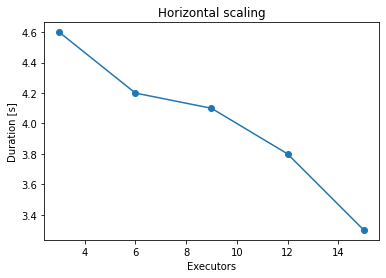

In [9]:
import matplotlib.pyplot as plt

executors = [3,6,9,12,15]
durations = [4.6, 4.2, 4.1, 3.8, 3.3]

plt.plot(executors, durations, marker='o')
plt.ylabel('Duration [s]')
plt.xlabel('Executors')
plt.title('Horizontal scaling')

plt.show()

<br><br>
<br><br>
<br><br>

### Coalesce (Repatition)

```batch_df.coalesce(15)```

We use the function ```coalesce()``` rather than ```repartition()``` because this command avoids full shuffles of a given dataset. We changed the number of repartitions and looked at the final performance. In detail, setting the coalesce parameter at $15$, $30$, $60$, $105$ does not affect much the final processing rate. 

### Shuffle partition

When changing the ```spark.sql.shuffle.partitions``` we observe the following. The default parameter is $15$ and if we increase in generale this value to multiples of the latter we get worse results. We suppose that this is related to the fact that with more shuffling, the cluster has to exchange more data among different Workers. In numbers:

* 15 shuffle partitions ~3.3 s
* 30 shuffle partitions ~7 s
* 60 shuffle partitions ~12 s

If we instead use a lower number than the default one, the computations are carried out with a higher processing time ~4 s. 

### Scaling with the input rate (kHz)

* 1 kHz - with 5 workers (15 executors): ~3.3 s
* 3 kHz - with 5 workers (15 executors): ~3.8 s
* 10 kHz - with 4 workers (12 executors): ~5.6 s 

In the last case, in order to maintain a stable data rate, we needed to free slave04 and dedicate all the resources to the Kafka Broker and the Producer (like it was a real Data Acquisition System). 

The scaling is not linear with the input rate. This is positive, because we can work with a lot of data and obtain results in a reasonable amount of time. Processing more data all together allows to exploit all the power of distributed computing.

# Conclusions

In the end, we have been able to develop a working Structured Streaming application where a DAQ is sending nearly 1000 samples per second to the Spark Master. This project allowed us to work with Big Data processing architectures for the first times, solve the problems related to Apache Kafka and Spark usage and spend quite some time in the tuning of the architecture.